In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *
import anndata as ad

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [3]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")


In [110]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [4]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [13]:
adata.obs['random_or_pattern'] = adata.obs['random_or_pattern'].replace('random','no_pattern')
adata.obs['pattern'] = adata.obs['pattern'].replace('random','no_pattern')

In [5]:
adata_strong = adata[adata.obs['pattern_strength']=='strong']

In [14]:
def balanceTrainingData_pattern_noPattern(adata, random_seed: int = 101):
    """
    Downsample the anndata object so that the test and control group for RF are equal size, while the control group is balanced for patterns and spot count. 
    Assumes there are less test observations than the other subcellular expression patterns combined. 

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    random_seed: int
        Seed for reproducability purposes. 
        
    Returns
    -------
    balanced_adata : ad.AnnData
        test and control group are equal size, while the control group is balanced for patterns and spot count
    """
        
    adata_test = adata[adata.obs['random_or_pattern']=='pattern']
    adata_control = adata[adata.obs['random_or_pattern']=='no_pattern']
    
    sample_size = len(adata_control)
    
    subset = adata_test.obs['n_spots_interval'].sample(n=sample_size, random_state=random_seed)
    
    adata_test_subset = adata_test[adata_test.obs.index.isin(subset.index)]
    
    # Concatenate adata_test and adata_control_subset
    adata = ad.concat([adata_test_subset, adata_control])

    return adata

In [97]:
adata_train.obs['random_or_pattern'].value_counts()

pattern       382233
no_pattern     50344
Name: random_or_pattern, dtype: int64

In [95]:
test = adata_train[adata_train.obs['random_or_pattern']=='pattern']
test.obs['n_spots_interval'].value_counts(normalize=True)

100+      0.412228
90-100    0.069002
80-90     0.068971
10-20     0.068835
70-80     0.068785
20-30     0.068558
40-50     0.068087
50-60     0.067310
30-40     0.066857
0-10      0.041367
Name: n_spots_interval, dtype: float64

In [7]:
def balanceTrainingData(adata, testPattern: str = 'pericellular', include_random: bool = False, random_seed: int = 101):
    """
    Downsample the anndata object so that the test and control group for RF are equal size, while the control group is balanced for patterns and spot count. 
    Assumes there are less test observations than the other subcellular expression patterns combined. 

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    testPattern : str
        Type of subcellular expression pattern you want to use as the test case. All other patterns will be used as control. 
    pattern_no_pattern: bool
        True: test pattern or no pattern, False: test patterns versus other patterns. Default is False.
    include_random: bool
        Whether the `no_pattern` pattern is included in the data or not. Default is False. 
    random_seed: int
        Seed for reproducability purposes. 
        
    Returns
    -------
    balanced_adata : ad.AnnData
        test and control group are equal size, while the control group is balanced for patterns and spot count
    """

    if include_random == False:
        adata = adata[adata.obs['pattern']!='no_pattern'].copy()

    adata_test = adata[adata.obs['pattern']==testPattern]
    adata_control = adata[adata.obs['pattern']!=testPattern]

    sample_size = int(len(adata_test)/len(adata_control.obs['pattern'].unique()))
    pattern_groups = adata_control.obs.groupby('pattern')
    subset_obs_list = []

    # loop over group patterns, for each pattern, group by n_spots_interval. In those interval groups, sample `target_samplesize`. 
    for pattern, group in pattern_groups:
        subset = group['n_spots_interval'].sample(n=sample_size, random_state=random_seed)
        subset_obs_list.append(subset)
    
    # Concatenate all subset observations and use these indices to subset the adata_control AnnData object
    all_subset_obs = pd.concat(subset_obs_list)
    adata_control_subset = adata_control[adata_control.obs.index.isin(all_subset_obs.index)]
    
    # Concatenate adata_test and adata_control_subset
    adata = ad.concat([adata_test, adata_control_subset])
    adata.obs[testPattern] = np.where(adata.obs["pattern"] == testPattern, testPattern, "other")

    return adata

In [8]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

# Random Forest

## Pattern / no pattern

In [18]:
# ONLY FOR TRAINING OF THE RF
adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

In [19]:
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train)
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test)

In [15]:
adata_train_balanced_pattern = balanceTrainingData(adata_train, testPattern = 'pericellular', include_random = False, random_seed = seed)
adata_test_balanced_pattern = balanceTrainingData(adata_test, testPattern = 'pericellular', include_random = False, random_seed = seed)

In [40]:
adata_train_balanced_pattern.obs['pattern'].value_counts()

pericellular    50320
cell-edge        6290
extranuclear     6290
foci             6290
intranuclear     6290
nuclear-edge     6290
perinuclear      6290
protrusion       6290
no_pattern       6290
Name: pattern, dtype: int64

In [45]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#out of bag score during training
rf_classifier.oob_score_

0.9600394842999049

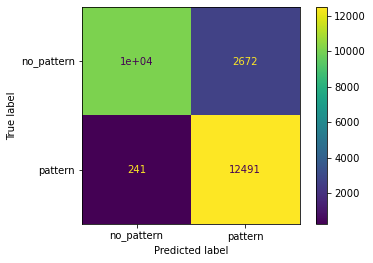

In [46]:
test_extranuclear = rf_classifier.predict(adata_test_balanced.obsm["latent"])

confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

In [ ]:
print("f1 score: ", fbeta_score(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, pos_label='no_pattern'))

f1 score:  0.8955726832765729
inverted f1 score:  0.8735292840706812


Make random the desired pattern to score on, so that the F1 will be selecting for the best true negative. 

In [58]:
adata_train_labels = adata_train_balanced.copy()
pattern_mapping = {'pattern': 1, 'no_pattern': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [59]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}
f_scorer_precision = make_scorer(fbeta_score, beta=0.5) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='roc_auc', verbose=3, error_score='raise', n_jobs = 5)
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'mean_fit_time': array([16.5635808 , 24.51412659, 32.49194579, 40.33258028]), 'std_fit_time': array([0.63372168, 1.0884875 , 1.53532241, 1.95497825]), 'mean_score_time': array([0.19381657, 0.18845201, 0.18224463, 0.17917776]), 'std_score_time': array([0.01779801, 0.01738824, 0.01672054, 0.01573796]), 'param_max_features': masked_array(data=[2, 3, 4, 5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}], 'split0_test_score': array([0.91063477, 0.91094238, 0.91035068, 0.90996012]), 'split1_test_score': array([0.98084836, 0.98101615, 0.98030512, 0.980007  ]), 'split2_test_score': array([0.98391185, 0.9842472 , 0.98443334, 0.98437324]), 'split3_test_score': array([0.98720169, 0.98783447, 0.98791014, 0.98887897]), 'split4_test_score': array([0.98554207, 0.98510281, 0.98571303, 0.98526644]),

In [60]:
adata_train_labels = adata_train_balanced.copy()
pattern_mapping = {'pattern': 0, 'no_pattern': 1}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [57]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}
f_scorer_precision = make_scorer(fbeta_score, beta=2) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. But now it is reversed because we say that random is the TP, so we want to reduce FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='roc_auc', verbose=3, error_score='raise', n_jobs = 5)
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'mean_fit_time': array([16.51269259, 24.32979774, 32.24488626, 40.18910041]), 'std_fit_time': array([0.63910487, 1.09279731, 1.51370771, 1.89662738]), 'mean_score_time': array([0.19818406, 0.1882648 , 0.18411303, 0.18080006]), 'std_score_time': array([0.02142343, 0.01743964, 0.01668881, 0.01574771]), 'param_max_features': masked_array(data=[2, 3, 4, 5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}], 'split0_test_score': array([0.89824522, 0.89993417, 0.89827226, 0.89900528]), 'split1_test_score': array([0.94075834, 0.94260204, 0.94130448, 0.94026809]), 'split2_test_score': array([0.92989843, 0.93069663, 0.93046688, 0.93186853]), 'split3_test_score': array([0.93373011, 0.9358412 , 0.93530225, 0.93462533]), 'split4_test_score': array([0.93932916, 0.93874209, 0.93914155, 0.93874169]), 'mean_test_score': array([0.92839225, 0.92956322, 0.9288974

In [69]:
train_accuracy = []
test_accuracy = []
for count in tqdm(range(50, 401, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=3, bootstrap=True, oob_score=True, n_jobs = 4)
    rf_classifier.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict_proba(adata_train_balanced.obsm["latent"])[:,1]
    test_pred = rf_classifier.predict_proba(adata_test_balanced.obsm["latent"])[:,1]

    # Obtain training and validation F1 score. 
    train_f1 = roc_auc_score(adata_train_balanced.obs["random_or_pattern"], train_pred)
    test_f1 = roc_auc_score(adata_test_balanced.obs["random_or_pattern"], test_pred)

    #append scores to lists
    train_accuracy.append(train_f1)
    test_accuracy.append(test_f1)

100%|██████████| 8/8 [02:40<00:00, 20.00s/it]


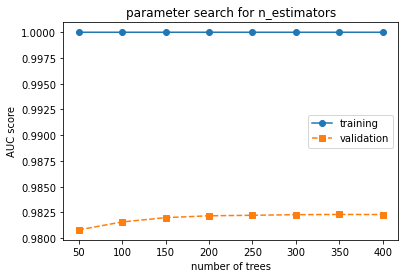

In [70]:
plt.figure()

x_values = range(50, 401, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, test_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [71]:
test_accuracy

[0.9808025904435174,
 0.9815762335131588,
 0.9819935987444689,
 0.9821746462933534,
 0.9822240559852554,
 0.9822836906055962,
 0.9823046031289182,
 0.9822966329282894]

There is hardly any improvement with more trees in the random forest, will chose 200

In [21]:
# create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, random_state=101)

In [68]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train[adata_train.obs["pattern_strength"]!="low"])
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test[adata_test.obs["pattern_strength"]!="low"])

In [69]:
test_pred_balanced = rf_pattern_balanced.predict(adata_test_balanced.obsm["latent"])
test_pred_unbalanced = rf_pattern_unbalanced.predict(adata_test_balanced.obsm["latent"])
pred_balanced = rf_pattern_balanced.predict_proba(adata_test_balanced.obsm["latent"])[:,1]
pred_unbalanced = rf_pattern_unbalanced.predict_proba(adata_test_balanced.obsm["latent"])[:,1]

print("balanced")
print("f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))
print("auc: ", roc_auc_score(adata_test_balanced.obs["random_or_pattern"], pred_balanced))

print("unbalanced")
print("f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))
print("auc: ", roc_auc_score(adata_test_balanced.obs["random_or_pattern"], pred_unbalanced))


balanced
f1 score:  0.821451131586399
inverted f1 score:  0.821451131586399
auc:  0.9232959064263704
unbalanced
f1 score:  0.8401140969824351
inverted f1 score:  0.8401140969824351
auc:  0.923564545551847


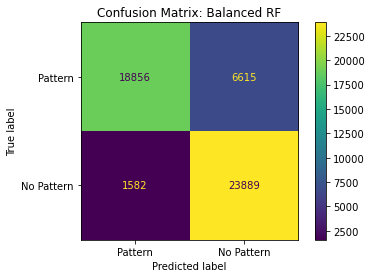

In [70]:
confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, labels = ["pattern", "no_pattern"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pattern", "No Pattern"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF")
plt.show()

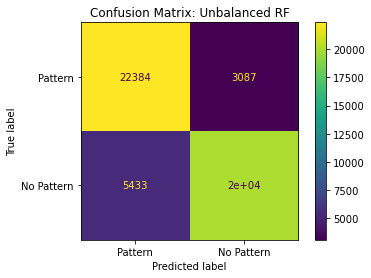

In [71]:
confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, labels = ["pattern", "no_pattern"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pattern", "No Pattern"]) 
cm_display.plot()
plt.title("Confusion Matrix: Unbalanced RF")
plt.show()

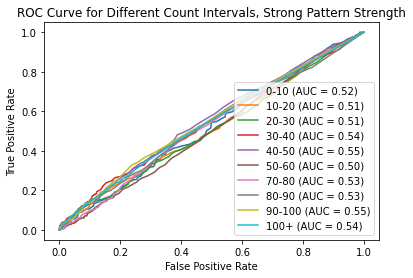

In [137]:
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_classifier.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Different Count Intervals, Strong Pattern Strength")
ax.plot(np.arange(0,1,5),np.arange(0,1,5))

plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [18]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [54]:
import pickle

path = f"temp_objects/rf_pattern_noPattern.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    rf_pattern_unbalanced = pickle.load(p)

In [55]:
path = f"temp_objects/rf_balanced/rf_pattern.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

In [16]:
adata_test_balanced

AnnData object with n_obs × n_vars = 25464 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    obsm: 'latent'

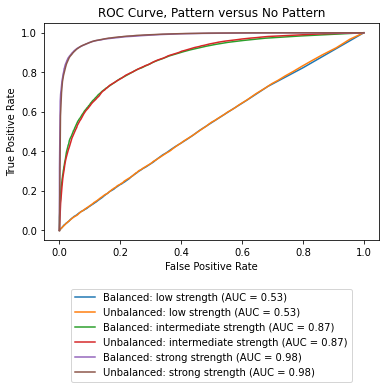

In [21]:
pattern_strength = ["low", "intermediate", "strong"]
models= {"Balanced: ": rf_classifier,"Unbalanced: ": rf_unbalanced}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = adata_test_balanced[adata_test_balanced.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['random_or_pattern'],
            test_pred, 
            pos_label = "pattern",
            name = f"{name}{strength} strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pattern versus No Pattern"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [221]:
pattern_strength = ["low", "intermediate", "strong"]
models= {"Balanced: ": rf_classifier,"Unbalanced: ": rf_unbalanced}
model = rf_unbalanced

adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="strong"]
test_pred = model.predict(adata_test_strength.obsm["latent"])

In [89]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [91]:
adata_test.obs["pattern_strength"].unique()

array(['strong', 'intermediate', 'low'], dtype=object)

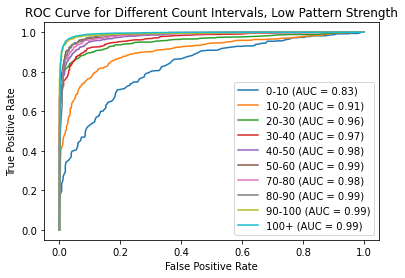

In [147]:
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_classifier.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Different Count Intervals, Low Pattern Strength")

plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

## Test RF pattern no pattern, on strong + intermediate data

In [53]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

adata_train_strength = adata_train[adata_train.obs["pattern_strength"]!="low"]
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train_strength)
adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="low"]
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)

In [97]:
# create random forest classifier and fit on training data
rf_mixed_strength = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_mixed_strength.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

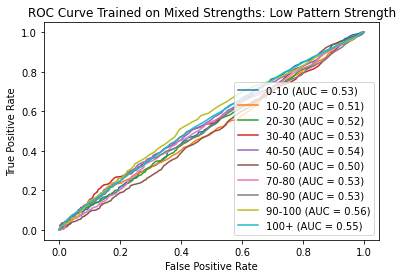

In [102]:
adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="low"]
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_mixed_strength.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve Trained on Mixed Strengths: Low Pattern Strength")


plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [23]:
import pickle

In [103]:
rf_pattern_mixed_trained = rf_classifier
path = f"temp_objects/rf_balanced/rf_intermediate_strong_trained.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pattern_mixed_trained, f)

In [24]:
rf_pattern_balanced_singlejob = rf_classifier
path = f"temp_objects/rf_balanced/rf_pattern_balanced_singlejob.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pattern_balanced_singlejob, f)

## Random Forest - Separate Binary classifiers

In [112]:
adata = adata_mixed_cellID
adata_strong = adata[adata.obs['pattern_strength']=='strong']
adata_train, adata_test = train_test(adata_strong, seed=101, split_per_cellID = True)

In [39]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [ ]:
adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

In [110]:
adata_train_balanced_pattern = balanceTrainingData(adata_train, testPattern = 'pericellular', include_random = False, random_seed = seed)
adata_test_balanced_pattern = balanceTrainingData(adata_test, testPattern = 'pericellular', include_random = False, random_seed = seed)

In [113]:
strength = "strong"
adata_train_strength = adata_train[adata_train.obs['pattern_strength']==strength]
adata_test_strength = adata_test[adata_test.obs['pattern_strength']==strength]
patterns = adata_train[adata_train.obs['pattern']!='random'].obs['pattern'].unique()
train_data = {}
test_data = {}

for pattern in patterns:
    adata_train_strength.obs[pattern] = np.where(adata_train_strength.obs["pattern"] == pattern, pattern, "other")
    adata_test_strength.obs[pattern] = np.where(adata_test_strength.obs["pattern"] == pattern, pattern, "other")
    train_data[pattern] = balanceTrainingData(adata_train_strength, testPattern = pattern, include_random = False, random_seed = seed)
    test_data[pattern] = balanceTrainingData(adata_test_strength, testPattern = pattern, include_random = False, random_seed = seed)


<ipython-input-113-10d6e7746350>:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_strength.obs[pattern] = np.where(adata_train_strength.obs["pattern"] == pattern, pattern, "other")
<ipython-input-113-10d6e7746350>:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_strength.obs[pattern] = np.where(adata_test_strength.obs["pattern"] == pattern, pattern, "other")


f1 score:  0.0028217588963787427
inverted f1 score:  0.6663169490636311
auc:  0.5113824887244516


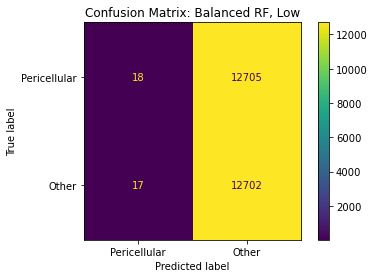

In [51]:
 # create random forest classifier EXCLUDING random
#rf_pericellular = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
#rf_pericellular.fit(train_data['pericellular'].obsm["latent"], train_data['pericellular'].obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular.predict(test_data['pericellular'].obsm["latent"])
test_peri = rf_pericellular.predict_proba(test_data['pericellular'].obsm["latent"])


print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='other'))
print("auc: ", roc_auc_score(test_data['pericellular'].obs["pericellular"], test_peri[:,1]))

confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular, labels = ["pericellular","other"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pericellular", "Other"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF, Low")
plt.show()

f1 score:  0.954891994917408
inverted f1 score:  0.9558457711442787
auc:  0.9928819174214558


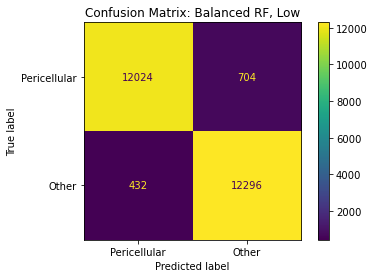

In [114]:
 # create random forest classifier EXCLUDING random
rf_pericellular_mixed = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_pericellular_mixed.fit(train_data['pericellular'].obsm["latent"], train_data['pericellular'].obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular_mixed.predict(test_data['pericellular'].obsm["latent"])
test_peri = rf_pericellular_mixed.predict_proba(test_data['pericellular'].obsm["latent"])


print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='other'))
print("auc: ", roc_auc_score(test_data['pericellular'].obs["pericellular"], test_peri[:,1]))

confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular, labels = ["pericellular","other"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pericellular", "Other"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF, Low")
plt.show()

In [115]:
import pickle
patterns = {'pericellular_balanced_mixedIDs': rf_pericellular_mixed}

for key, value in patterns.items():
    path = f"temp_objects/rf_balanced/rf_{key}.pkl"

    # Open the file in write-binary mode and dump the object
    with open(path, 'wb') as f:
        pickle.dump(value, f)

In [20]:
import pickle

path = "temp_objects/rf_balanced/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    peri_balanced = pickle.load(p)

In [26]:
path = "temp_objects/f1_negative_cellID_split/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    peri_model_splitID = pickle.load(p)

In [44]:
test_data['pericellular'].obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,...,corresponding_dapis,train_or_val,original_image_paths,pattern_strength,cell-edge,extranuclear,foci,intranuclear,nuclear-edge,pericellular
945765,pericellular,pattern,100,100+,137,blank,163,120-180,1.5,0.5,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,pericellular
945766,pericellular,pattern,100,100+,137,blank,210,180-240,1.5,0.5,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,pericellular
945767,pericellular,pattern,100,100+,137,blank,300,240-300,1.5,0.5,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,pericellular
945768,pericellular,pattern,100,100+,137,blank,339,300+,1.5,0.5,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,pericellular
945769,pericellular,pattern,100,100+,137,blank,89,60-120,1.5,0.5,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,pericellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437176,protrusion,pattern,64,70-80,67,blank,199,180-240,1.5,0.2,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,other
1437191,protrusion,pattern,65,70-80,22,blank,139,120-180,1.5,0.2,...,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,other
1437381,protrusion,pattern,75,80-90,222,blank,113,60-120,1.5,0.2,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,other
1437475,protrusion,pattern,7,0-10,6,blank,12,0-60,1.5,0.2,...,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate,other,other,other,other,other,other


f1 score:  0.0001571832756994656
inverted f1 score:  0.6666142557651992
auc:  0.5071325277004771


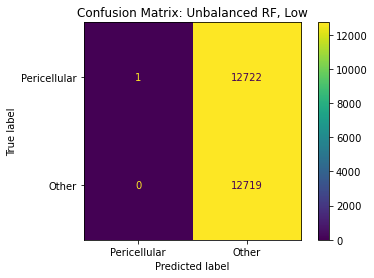

In [52]:
test_pericellular_old = peri_model_splitID.predict(test_data['pericellular'].obsm["latent"])
test_peri = peri_model_splitID.predict_proba(test_data['pericellular'].obsm["latent"])

print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular_old, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular_old, pos_label='other'))
print("auc: ", roc_auc_score(test_data['pericellular'].obs["pericellular"], test_peri[:,1]))

confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular_old, labels = ["pericellular","other"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pericellular", "Other"]) 
cm_display.plot()
plt.title("Confusion Matrix: Unbalanced RF, Low")
plt.show()

In [158]:
adata_test_balanced.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths,pattern_strength
46,cell-edge,pattern,101,100+,182,blank,117,60-120,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
47,cell-edge,pattern,101,100+,182,blank,15,0-60,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
110,cell-edge,pattern,102,100+,212,blank,254,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
126,cell-edge,pattern,102,100+,48,blank,168,120-180,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
400,cell-edge,pattern,10,0-10,183,blank,250,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627102,no_pattern,no_pattern,99,100+,106,blank,189,180-240,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627103,no_pattern,no_pattern,99,100+,106,blank,230,180-240,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627104,no_pattern,no_pattern,99,100+,106,blank,272,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627105,no_pattern,no_pattern,99,100+,106,blank,340,300+,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low


In [164]:
test_peri = test_data['pericellular']
adata_test_strength = test_peri[test_peri.obs["pattern_strength"]=="low"]
adata_test_balanced.obs['n_spots_interval'].value_counts()

Series([], Name: n_spots_interval, dtype: int64)

In [176]:
models= {"Balanced: ": rf_pericellular,"Unbalanced: ": peri_model_splitID}
models

{'Balanced: ': RandomForestClassifier(max_features=3, n_estimators=150, n_jobs=4,
                        random_state=101),
 'Unbalanced: ': RandomForestClassifier(max_features=3, n_estimators=150, random_state=101)}

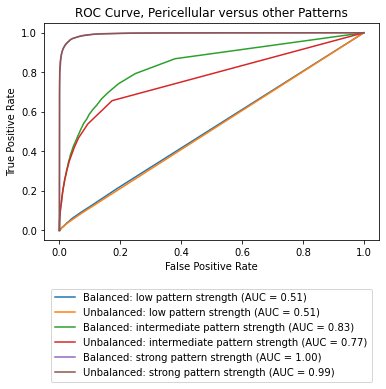

In [192]:
test_peri = test_data['pericellular']
pattern_strength = ["low", "intermediate", "strong"]

models= {"Balanced: ": rf_pericellular,"Unbalanced: ": peri_model_splitID}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = test_peri[test_peri.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pericellular versus other Patterns"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

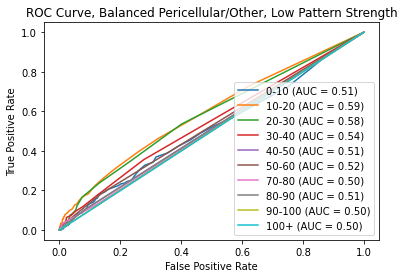

In [ ]:
test_peri = test_data['pericellular']
adata_test_strength = test_peri[test_peri.obs["pattern_strength"]=="low"]
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_strength[adata_test_strength.obs['n_spots_interval']==interval]
    test_pred = rf_pericellular.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['pericellular'],
        test_pred, 
        pos_label = "pericellular",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Balanced Pericellular/Other, Low Pattern Strength")


plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

## Saving and restoring RF objects

In [ ]:
import pickle
patterns = {'cellEdge': rf_cellEdge, 'foci': rf_foci, 'extranuclear': rf_extranuclear, 'intranuclear': rf_intranuclear, 'nuclearEdge': rf_nuclearEdge, 'pericellular': rf_pericellular, 'perinuclear': rf_perinuclear, 'protrusion': rf_protrusion}

for key, value in patterns.items():
    path = f"temp_objects/f1_negative_cellID_split/rf_{key}.pkl"

    # Open the file in write-binary mode and dump the object
    with open(path, 'wb') as f:
        pickle.dump(value, f)

In [7]:
import pickle

patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
models = {}

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/f1_negative_cellID_split/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        models[pattern] = pickle.load(p)

# 1 gene n cells

### Statistics 1 gene n cells

In [9]:
def subsetGenes_mediumCounts(adata, pattern: str = 'pericellular', mixed_patterns: bool = False, pattern_strength: str = "strong", random_seed: int = 101):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                               (adata.obs['n_spots_interval'] == '10-20') | (adata.obs['n_spots_interval'] == '20-30')
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()

    
    subset_dict = {}
    i = 0
    while len(adata_filtered.obs['cell_id'].unique()) > 0:
        grouped = adata_filtered.obs.groupby('cell_id')

        # For each group, select at most one item & concatenate results back into a DataFrame
        subsets = [group.sample(n=1, random_state = random_seed) for _, group in grouped]
        subset_obs = pd.concat(subsets)

        # Use this DataFrame to subset the original anndata object and store in dictionary, while omitting the selected cells from the original adata object
        count_subset = adata_filtered[adata_filtered.obs.index.isin(subset_obs.index)].copy()
        subset_dict[i] = count_subset
        adata_filtered = adata_filtered[~adata_filtered.obs.index.isin(subset_obs.index)].copy()
        i += 1

    return subset_dict

In [13]:
pericellular_dict_mid = subsetGenes_mediumCounts(adata_test, 'pericellular', pattern_strength = "strong")
random_dict_mid = subsetGenes_mediumCounts(adata_test, 'random')

In [17]:
pericellular_dict_mid.get(0).obs['n_spots_interval'].value_counts()

20-30    34
10-20    30
Name: n_spots_interval, dtype: int64

In [ ]:
pericellular_dict_low = subsetGenes(adata_test, 'pericellular', pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
pericellular_dict_high = subsetGenes(adata_test, 'pericellular', pattern_strength="low", count_threshold = 100, high_or_low = 'high')
random_dict_low = subsetGenes(adata_test, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)
random_dict_high = subsetGenes(adata_test, 'random', count_threshold = 100, high_or_low = 'high', mixed_counts=False)
pattern_dict_low = subsetGenes(adata_test, mixed_patterns = True, pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
pattern_dict_high = subsetGenes(adata_test, mixed_patterns = True, pattern_strength = "low", count_threshold = 100, high_or_low = 'high')

In [6]:
pericellular_dict_low = subsetGenes(adata_test, 'pericellular', pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
random_dict_low = subsetGenes(adata_test, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)

In [8]:
random_dict_low

{0: AnnData object with n_obs × n_vars = 64 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
     uns: 'test_cellIDs', 'train_cellIDs'
     obsm: 'latent',
 1: AnnData object with n_obs × n_vars = 64 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
     uns: 'test_cellIDs', 'train_cellIDs'
     obsm: 'latent',
 2: AnnData object with n_obs × n_vars = 64 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    

In [28]:
pericellular_dict_highweak = subsetGenes(adata_test, 'pericellular', pattern_strength="low", count_threshold = 100, high_or_low = 'high')
random_dict_high = subsetGenes(adata_test, 'random', count_threshold = 100, high_or_low = 'high', mixed_counts=False)
pattern_dict_high = subsetGenes(adata_test, mixed_patterns = True, pattern_strength = "low", count_threshold = 100, high_or_low = 'high')

In [11]:
import pickle

path = "temp_objects/rf_balanced/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    peri_balanced = pickle.load(p)

Order of predict_proba is in lexicoalphabetic order, so other = 0 & pericellular is 1, but in case of eg foci verus other, foci=0 and other = 1

In [30]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    pericellular_low = peri_balanced.predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,1]
    pericellular_high = peri_balanced.predict_proba(pericellular_dict_highweak.get(i).obsm["latent"])[:,1]
    random_low = peri_balanced.predict_proba(random_dict_low.get(i).obsm["latent"])[:,1]
    random_high = peri_balanced.predict_proba(random_dict_high.get(i).obsm["latent"])[:,1]
    pattern_low = peri_balanced.predict_proba(pattern_dict_low.get(i).obsm["latent"])[:,1]
    pattern_high = peri_balanced.predict_proba(pattern_dict_high.get(i).obsm["latent"])[:,1]
    for value in pericellular_low:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'gene_id': i})
    for value in pericellular_high: 
        rows.append({'prob_pattern': value, 'group': 'pericellular_high', 'gene_id': i})
    for value in random_low:
        rows.append({'prob_pattern': value, 'group': 'random_low', 'gene_id': i})
    for value in random_high:
        rows.append({'prob_pattern': value, 'group': 'random_high', 'gene_id': i})
    for value in pattern_low:
        rows.append({'prob_pattern': value, 'group': 'pattern_low', 'gene_id': i})
    for value in pattern_high:
        rows.append({'prob_pattern': value, 'group': 'pattern_high', 'gene_id': i})
df = pd.DataFrame(rows)

In [22]:
test = df[df['group']=='pattern_low']
test['prob_pattern'].mean()

0.2244140625

In [24]:
test = df[df['group']=='pericellular_low']
test['prob_pattern'].mean()

0.6082517482517482

In [107]:
df['group'].unique()

array(['pericellular_low', 'pericellular_high', 'random_low',
       'random_high', 'pattern_low', 'pattern_high'], dtype=object)

### Balanced graphs

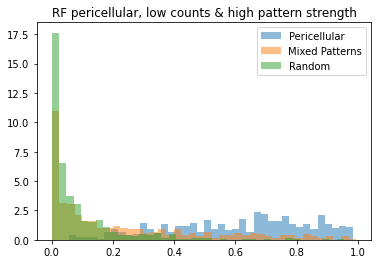

In [33]:
pattern = 'pericellular'
pericellular = df[(df['group']=='pericellular_low')]
pattern_low = df[(df['group']=='pattern_low')]
random_low = df[(df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(pattern_low['prob_pattern'], bins=40, alpha=0.5, label='Mixed Patterns', density=True)
plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random', density=True)

plt.title(f"RF {pattern}, low counts & high pattern strength")
plt.legend(loc='upper right')
plt.show()

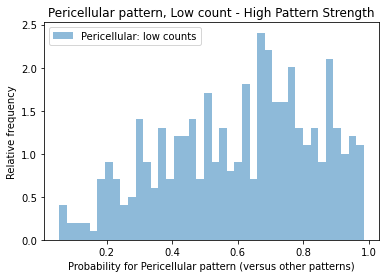

In [34]:
pattern = df[df['group']=='pericellular_low']
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular pattern, Low count - High Pattern Strength")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [42]:
pericellular_dict_low_testID = pericellular_dict_low

In [43]:
pericellular_dict_low_splitID = subsetGenes(adata, 'pericellular', pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')

In [133]:
adata_split = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [134]:
choices = ['strong', 'intermediate', 'low']
for adata in [adata_split, adata_all, adata_mixed_cellID]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [137]:
pericellular_dict_all = subsetGenes(adata_all, 'pericellular', pattern_strength = "strong", mixed_counts = True)
peri_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_cellID = subsetGenes(adata_split, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_testID = subsetGenes(adata_split[adata_split.obs['cell_id'].isin(adata_split.uns['test_cellIDs'])], 'pericellular', pattern_strength = "strong", mixed_counts = True)

In [136]:
import pickle

path1 = "temp_objects/rf_balanced/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path1, 'rb') as p:
    peri_balanced = pickle.load(p)

path2 = "temp_objects/incl_random/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path2, 'rb') as p:
    peri_random = pickle.load(p)

In [ ]:
pericellular_dict_low_all # all spots simulated embeddings
pericellular_dict_mixed_cellID # old model, mixed cell id's
pericellular_dict_low_testID # new model, split cell id's, test cell id's only.
pericellular_dict_low_splitID # new model, split cell id's, all id's combined.

In [138]:
rows = []
gene_id = np.array(range(10))
 
for model in [peri_balanced, peri_random,rf_pericellular_mixed]:
    for i in range(10):
        all_spots = model.predict_proba(pericellular_dict_all.get(i).obsm["latent"])[:,1]
        mixed_cellID = model.predict_proba(peri_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
        split_testID = model.predict_proba(pericellular_dict_split_testID.get(i).obsm["latent"])[:,1]
        split_allID = model.predict_proba(pericellular_dict_split_cellID.get(i).obsm["latent"])[:,1]
        for value in all_spots:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'all_spots', 'gene_id': i})
        for value in mixed_cellID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_cellID', 'gene_id': i})
        for value in split_testID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'split_testID', 'gene_id': i})
        for value in split_allID:
            rows.append({'prob_pattern': value, 'model':model, 'group': 'split_allID', 'gene_id': i})
df = pd.DataFrame(rows)

In [ ]:
all spots
custom panel, mixed cellID
custom panel, split cellID, test+train
custom panel, split cellID, test only
len(data['prob_pattern'].unique())

67


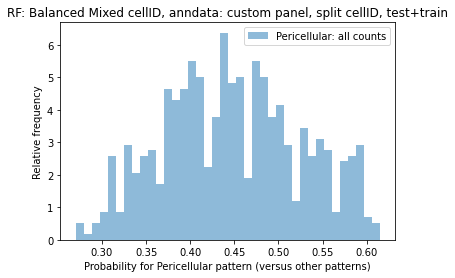

In [190]:
groups = ['all_spots','mixed_cellID','split_testID','split_allID']
models = [peri_balanced, peri_random, rf_pericellular_mixed]
data = df[(df['group']==groups[2])&(df['model']==models[2])]

print(len(data['prob_pattern'].unique()))
plt.hist(data['prob_pattern'], bins=38, alpha=0.5, label='Pericellular: all counts', density=True)

plt.title("RF: Balanced Mixed cellID, anndata: custom panel, split cellID, test+train")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Test balanced model see what comes out

In [45]:
peri_balanced

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [184]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_old_rf = rf_pericellular.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,1]
    for value in all_spots_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_old_model = pd.DataFrame(rows)

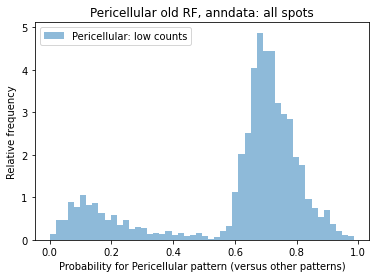

In [186]:
pattern = df_all_spots_old_model[(df_all_spots_old_model['RF_Classifier'] == 'pericellular') & (df_all_spots_old_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: all spots")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [187]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_old_rf = peri_model.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
    for value in mixed_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_new_model = pd.DataFrame(rows)

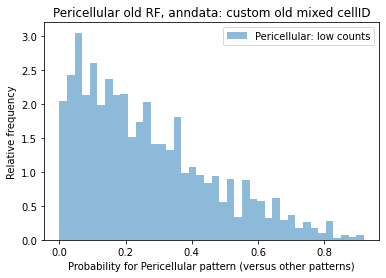

In [189]:
pattern = df_mixed_cellID_new_model[(df_mixed_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: custom old mixed cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

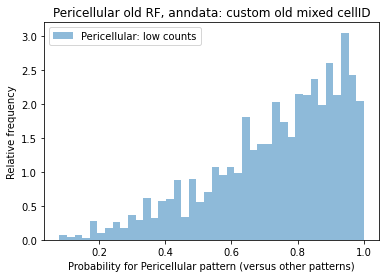

In [161]:
pattern = df_mixed_cellID_new_model[(df_mixed_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [190]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_old_rf = peri_model.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,1]
    for value in split_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_new_model = pd.DataFrame(rows)

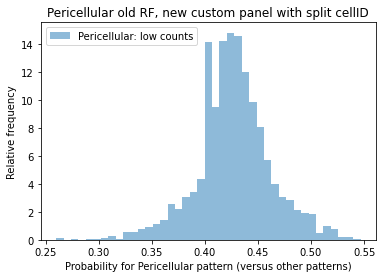

In [192]:
pattern = df_split_cellID_new_model[(df_split_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### Try with properly segregated test data for split cell ID

in the current version of splitcellID I have ~2040 datapoints. In the adata_test set there's only 507 elements that are pericellular, high pattern strength and count lower than 11. So will just use the entire test set iso dividing etc.

In [207]:
test = adata_test_pattern[adata_test_pattern.obs['pattern']=='pericellular']
pericellular_splitID_testset = test[test.obs['n_spots']<11]
#2040 current samplesize for split cellID

In [211]:
testsplit_cellID_random_rf = rf_pericellular.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

In [219]:
len(np.unique(testsplit_cellID_random_rf))

106

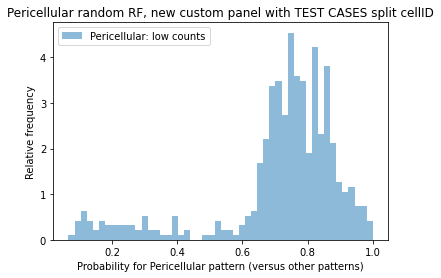

In [220]:

plt.hist(testsplit_cellID_random_rf, bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [221]:
len(np.unique(testsplit_cellID_new_rf))

131

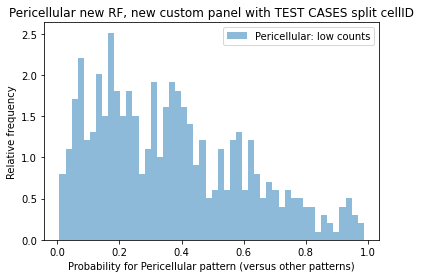

In [223]:
testsplit_cellID_new_rf = peri_model_splitID.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

plt.hist(testsplit_cellID_new_rf, bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

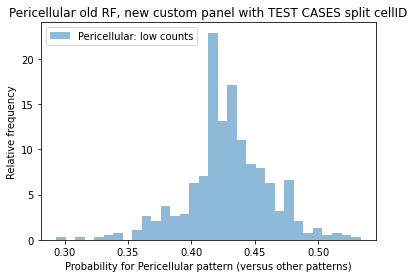

In [216]:
testsplit_cellID_old_rf = peri_model.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

plt.hist(testsplit_cellID_old_rf, bins=len(np.unique(testsplit_cellID_old_rf)), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### KNN comparison

In [54]:
knn_classifier_pericellular_nonnormalized

KNeighborsClassifier(n_jobs=3, n_neighbors=69, weights='distance')

In [66]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,0]
    for value in all_spots_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_knn_model = pd.DataFrame(rows)

In [39]:
df_all_spots_knn_model['prob_pattern'].value_counts()

1.0    2674
Name: prob_pattern, dtype: int64

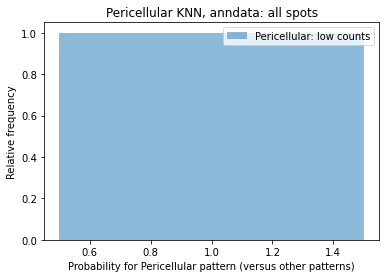

In [67]:
pattern = df_all_spots_knn_model[(df_all_spots_knn_model['RF_Classifier'] == 'pericellular') & (df_all_spots_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [68]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,0]
    for value in mixed_cellID_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_knn_model = pd.DataFrame(rows)

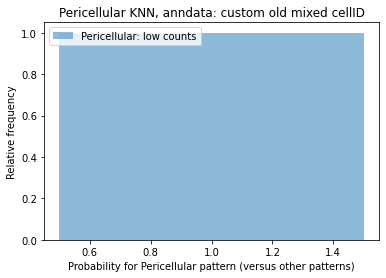

In [69]:
pattern = df_mixed_cellID_knn_model[(df_mixed_cellID_knn_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [70]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,0]
    for value in split_cellID_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_knn_model = pd.DataFrame(rows)

In [74]:
df_split_cellID_knn_model['prob_pattern'].value_counts()

0.000000    1611
1.000000      12
0.985327       1
0.971366       1
0.740218       1
            ... 
0.958818       1
0.645343       1
0.946070       1
0.984849       1
0.832062       1
Name: prob_pattern, Length: 419, dtype: int64

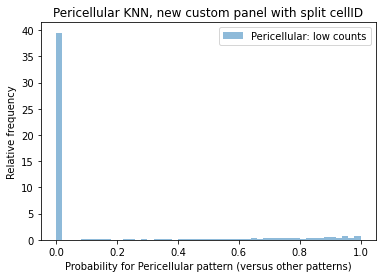

In [73]:
pattern = df_split_cellID_knn_model[(df_split_cellID_knn_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [ ]:
test_cellID_knn = knn_classifier_pericellular.predict_proba(test_ad.obsm["latent"])[:,0]